In [26]:
plt.rcParams["figure.figsize"] = (30,20)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, probplot
from sklearn import preprocessing
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [27]:
def read_unirep(file_path):
    """
    Parse a Unirep file.
    """
    data_matrix = []
    with open(file_path) as fp:
        data = fp.readlines()
    for i, line in enumerate(data):
        if line[0] == '>':
            data_matrix.append(np.array(
                data[i + 1].strip().split(sep=' '),
                dtype=np.float64))
    return np.array(data_matrix)

In [28]:
def prob_plot(dataset):
    fig, axs = plt.subplots(8, 8)
    for j in range(1, 65):
        plt.subplot(8, 8, j)
        probplot(dataset[j-1], plot=plt)
        plt.title("feature {}".format(j))
        plt.xlabel("")
        plt.ylabel("")
    plt.tight_layout()
    plt.show()

In [29]:
def hist_plot(dataset):
    fig, axs = plt.subplots(8, 8)
    for j in range(1, 65):
        plt.subplot(8, 8, j)
        plt.hist(dataset[j-1], bins=40)
        plt.title("feature {}".format(j))
        plt.xlabel("")
        plt.ylabel("")
    plt.tight_layout()
    plt.show()

In [30]:
raw_cyt = read_unirep("cytoxplasmUniRef50(1).unirep")
raw_peri = read_unirep("periplasmUniRef50(1).unirep")
all_raw = np.concatenate((raw_cyt, raw_peri))

In [31]:
print(len(raw_cyt))
print(len(raw_peri))
print(len(all_raw))

16408
4160
20568


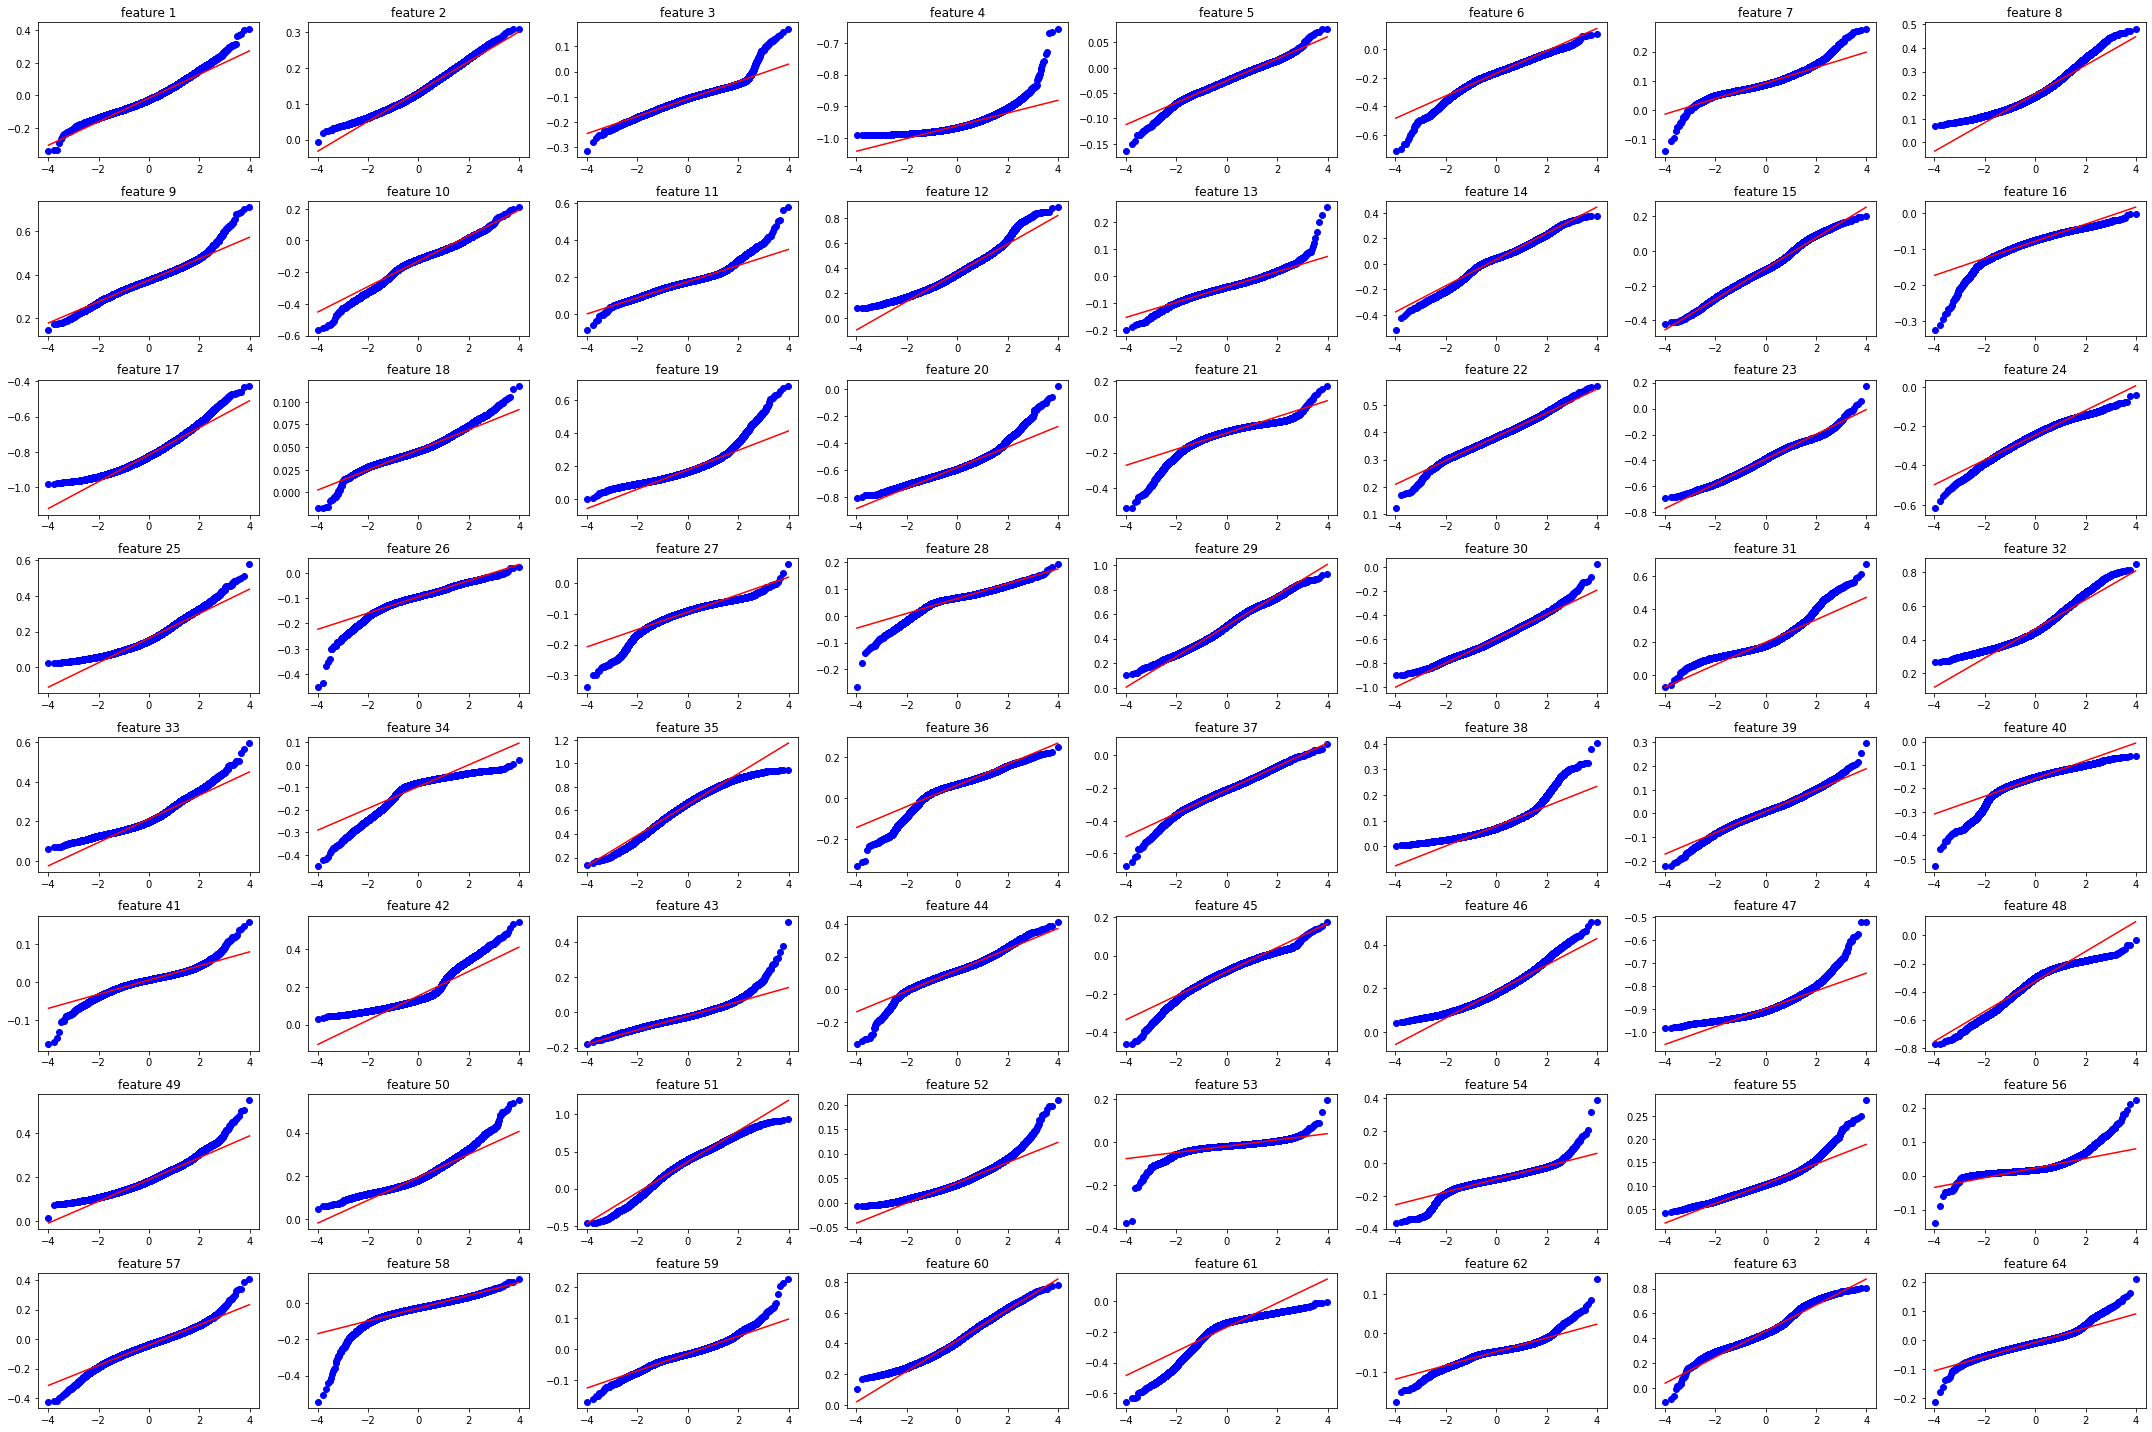

In [32]:
prob_plot(all_raw.T)

These are probability plot (similar to QQ plots). When the data are normally distributed, the blue curve fits the linear diagonal. Here, we can see that most features doesn't follow a normal distribution. We will try to pre-process the data to get closer to the normal distribution. 

Note: Shapiro-wilk doesn't work, there are too many samples, the test becomes too sensitive and doesn't declares anything as normally distributed.

In [16]:
log_transform = np.log(all_raw.T + 1)

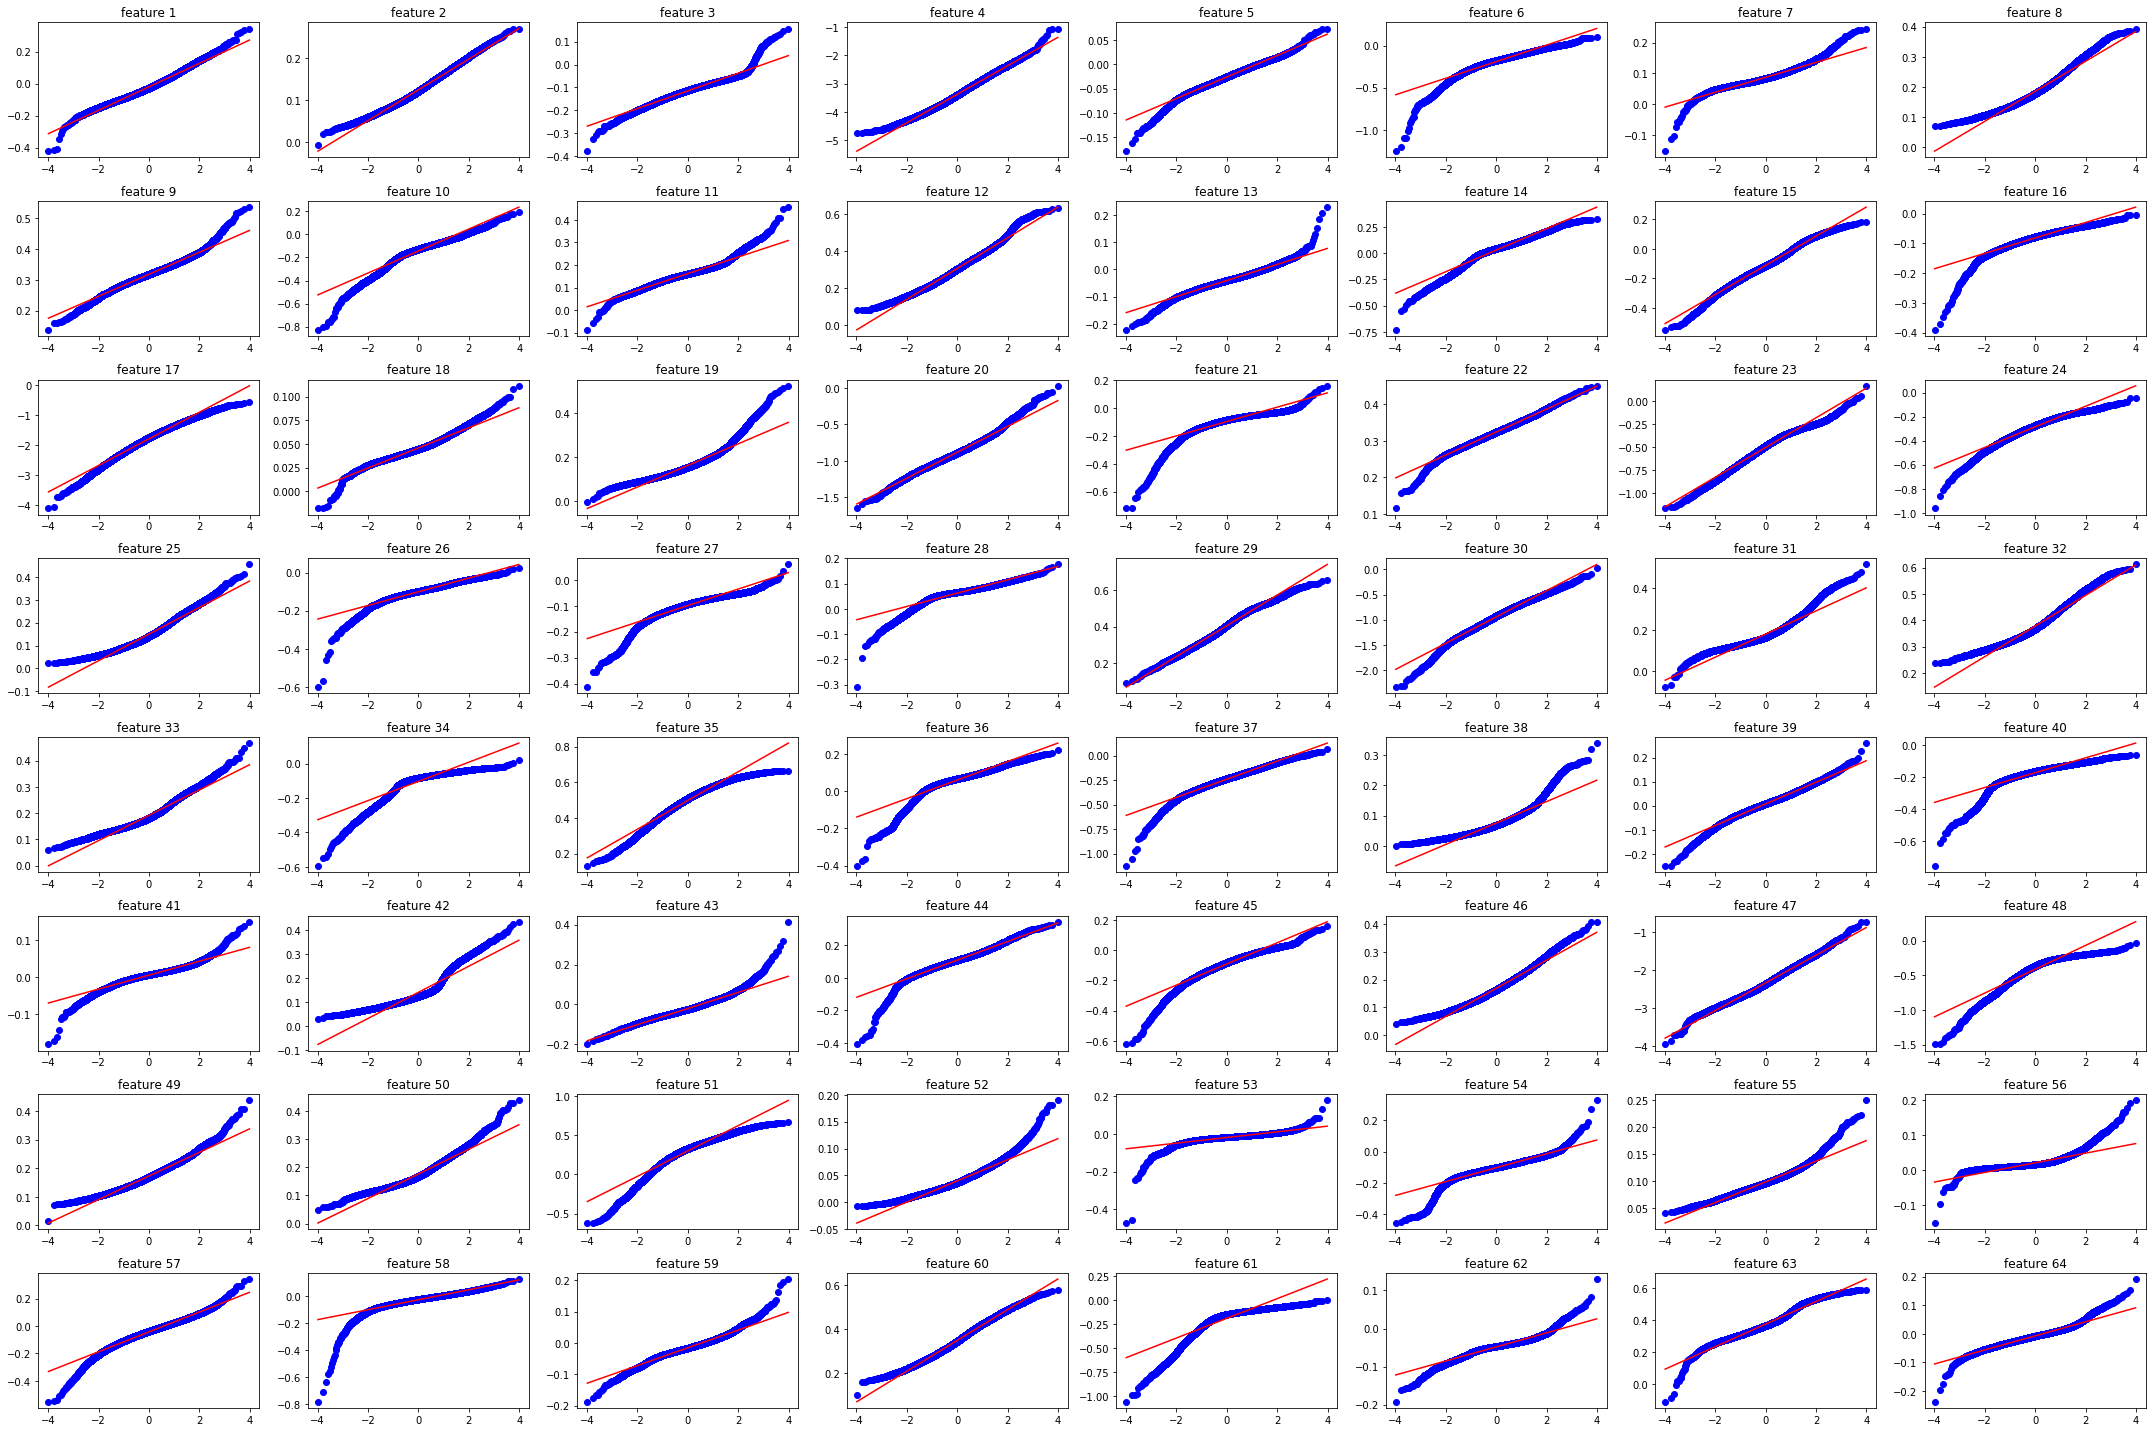

In [17]:
prob_plot(log_transform)

Log transform gives better results for some features, but not for all.

In [18]:
scaled_transfrom = preprocessing.scale(all_raw.T)

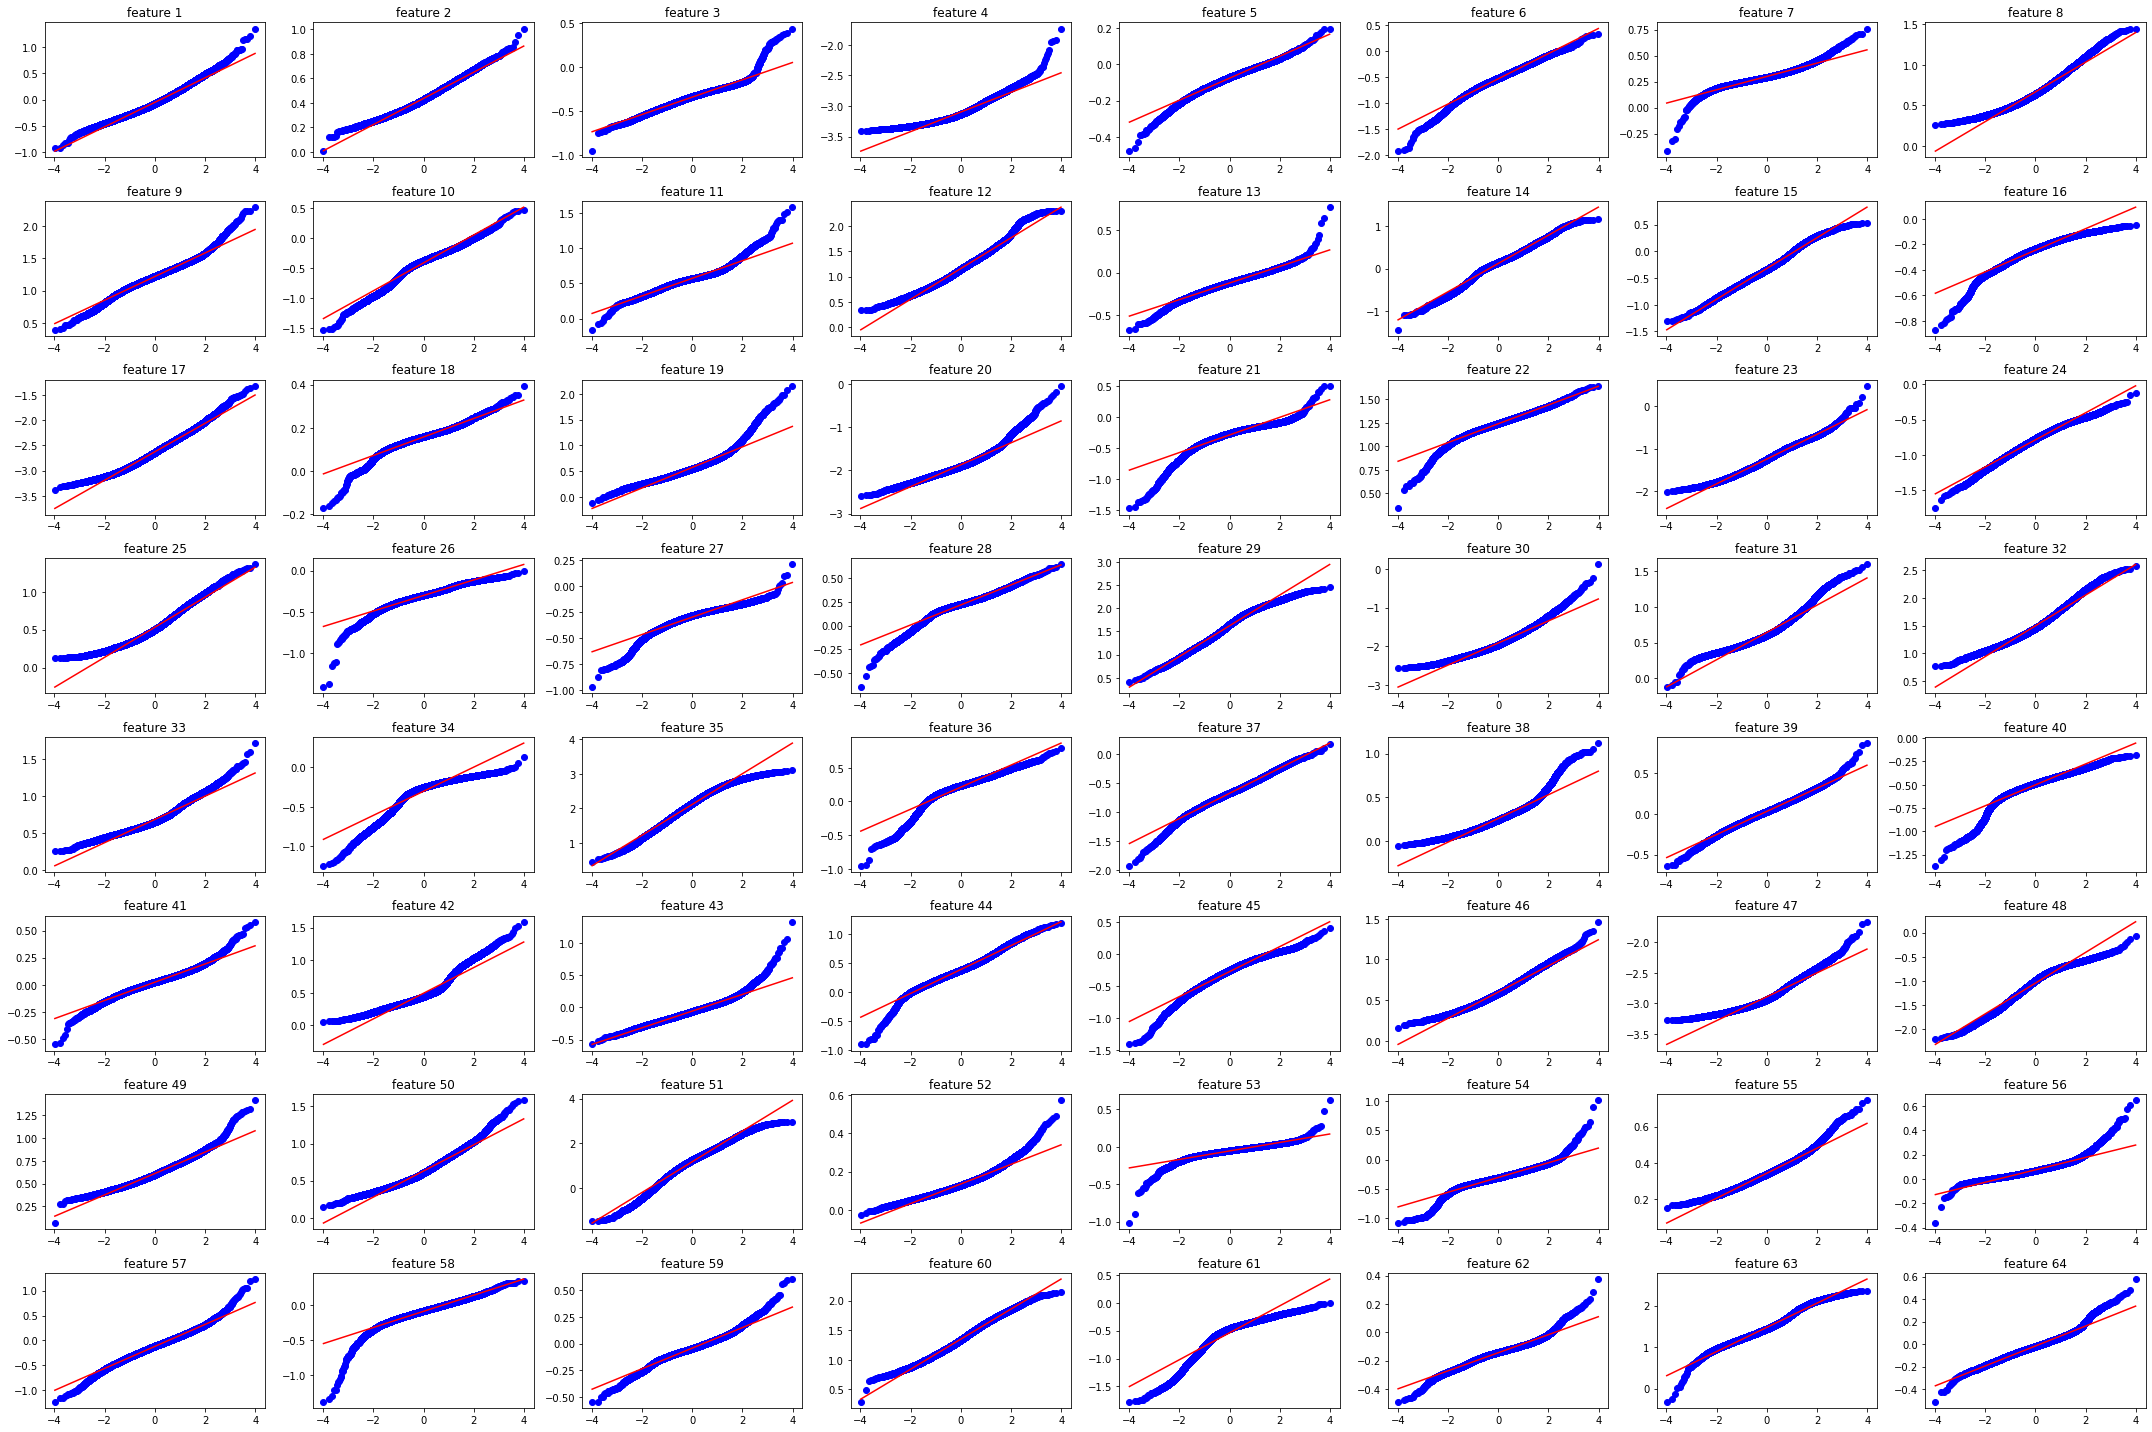

In [19]:
prob_plot(scaled_transfrom)

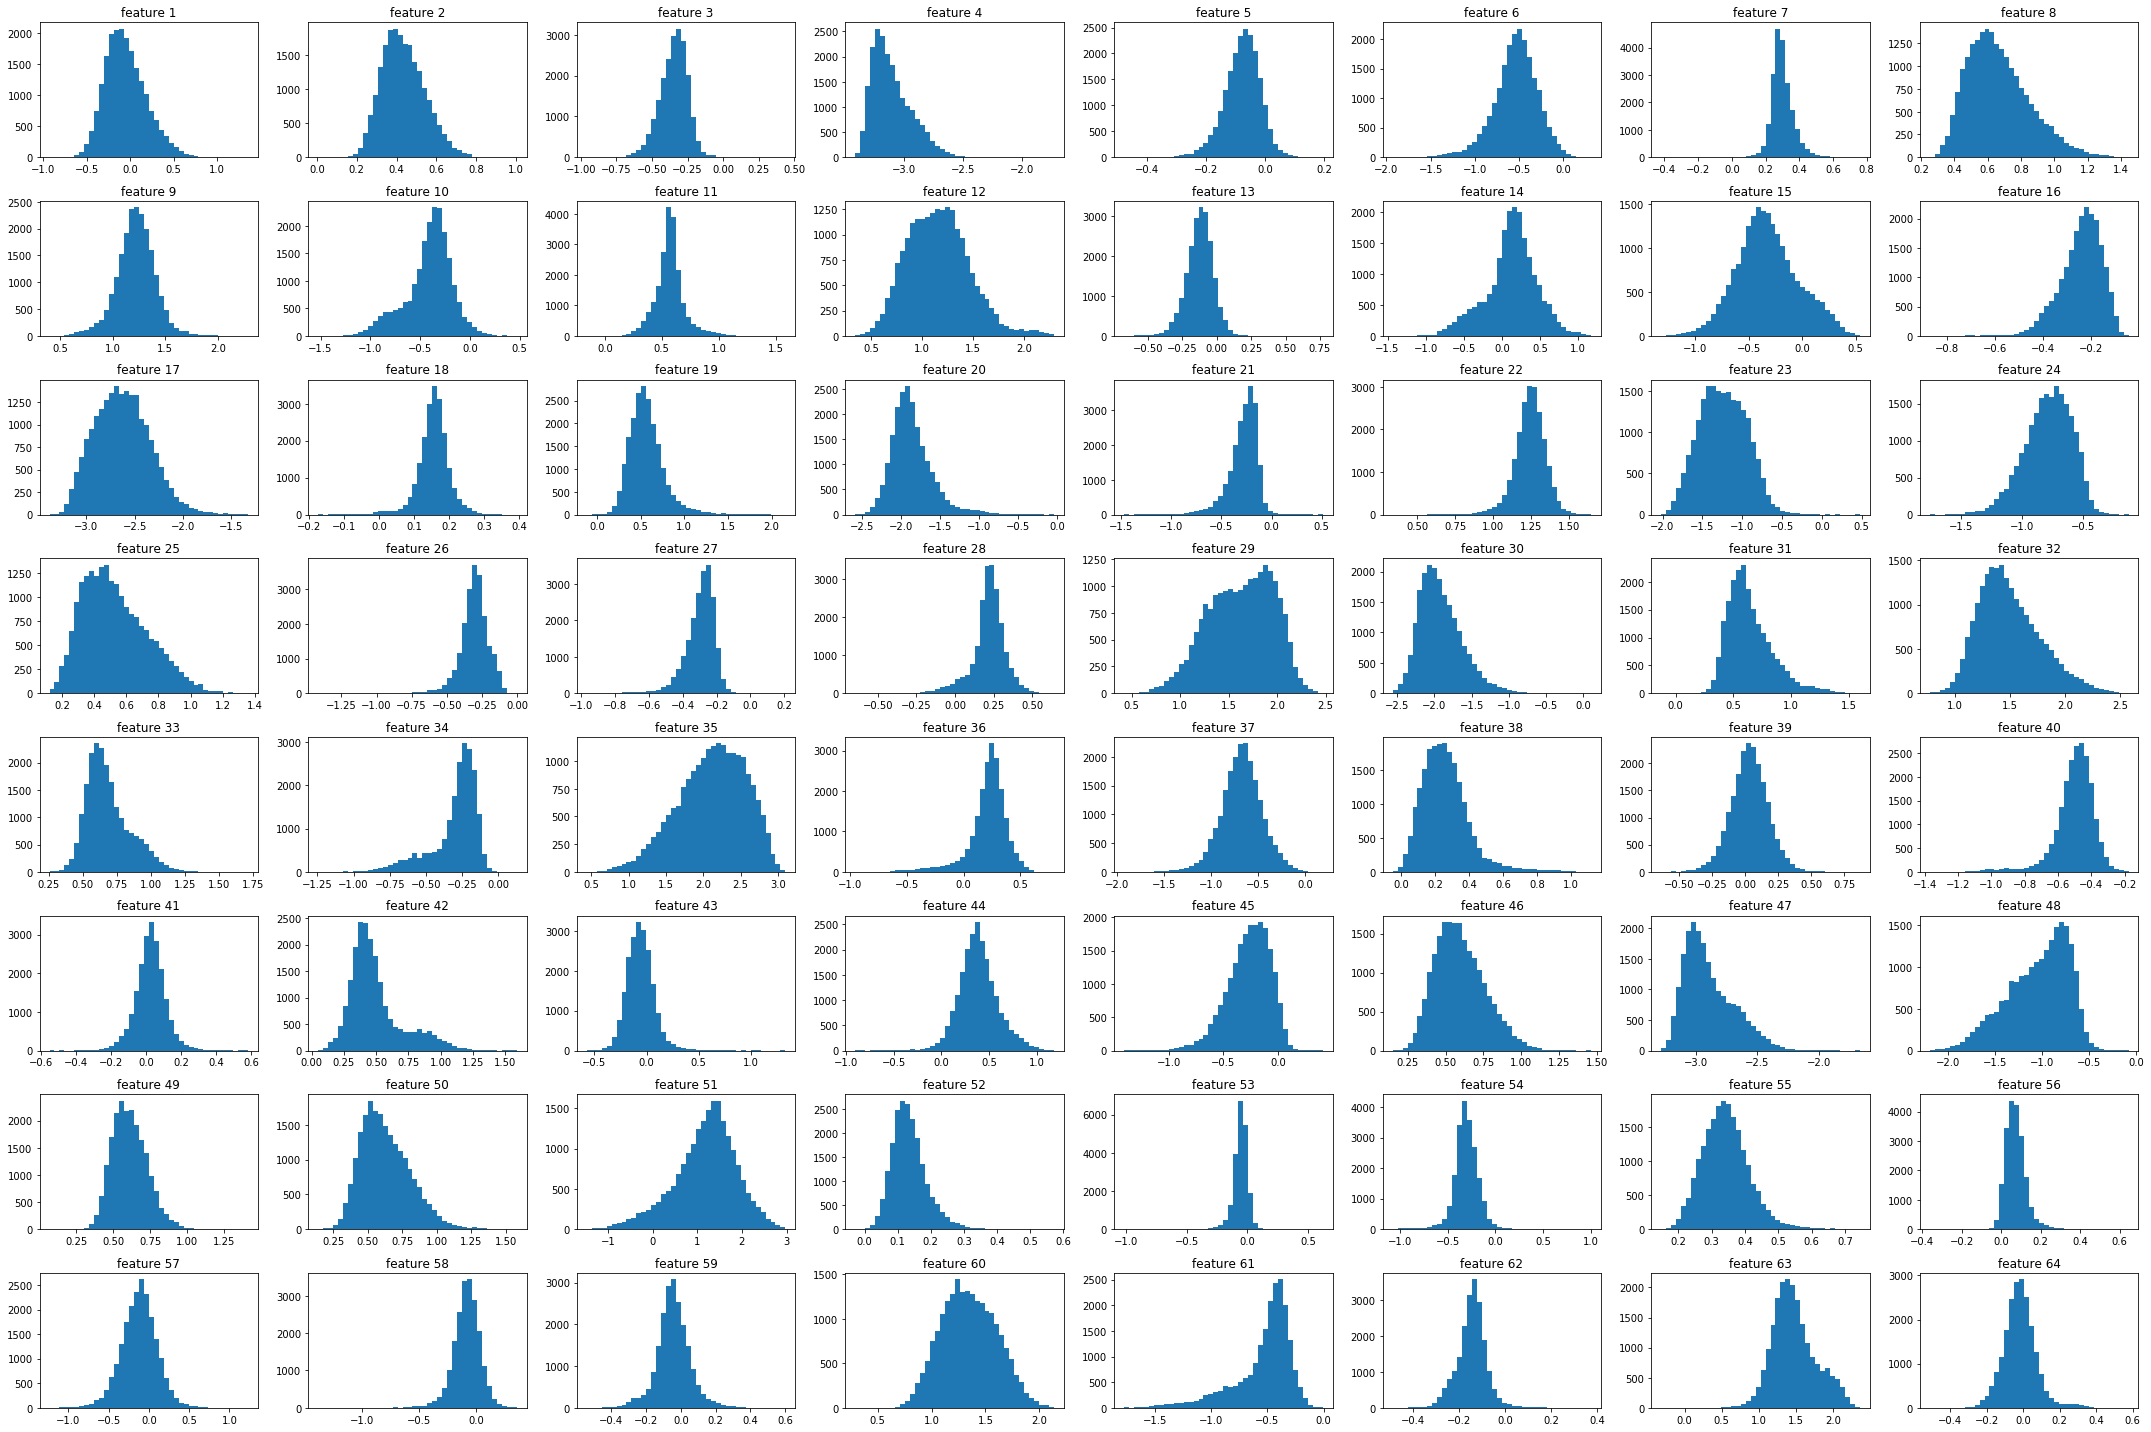

In [20]:
hist_plot(scaled_transfrom)

In [21]:
# Gives value 1 to cytoplasmic proteins, 0 to others.
labels = np.zeros(len(scaled_transfrom.T))
labels[0:len(raw_cyt)] = 1

In [22]:
labels

array([1., 1., 1., ..., 0., 0., 0.])

In [39]:
# Generate PCA object.
pca = PCA()
# Fit PCA to the data.
pca.fit(scaled_transfrom.T)
print(pca.explained_variance_ratio_)
pca_data = pca.fit_transform(scaled_transfrom.T)

[3.11859247e-01 2.21902993e-01 1.52761839e-01 9.58710175e-02
 5.66382139e-02 3.15625993e-02 2.73623110e-02 2.21122478e-02
 1.46711854e-02 9.04669387e-03 6.85697864e-03 6.11287507e-03
 4.99998135e-03 4.07225833e-03 3.74161728e-03 3.48841833e-03
 3.01020321e-03 2.18310854e-03 2.00352996e-03 1.89317066e-03
 1.61928829e-03 1.58581867e-03 1.36559160e-03 1.20194103e-03
 1.03695308e-03 1.00046403e-03 9.37043201e-04 8.15190801e-04
 7.18031081e-04 6.66598269e-04 5.85172165e-04 5.47628833e-04
 4.73601154e-04 4.51133455e-04 3.98225463e-04 3.59204810e-04
 3.54955374e-04 3.22367645e-04 2.88912199e-04 2.66999785e-04
 2.53272519e-04 2.32675499e-04 2.18342203e-04 2.09585533e-04
 1.97416319e-04 1.80728144e-04 1.69535222e-04 1.56299809e-04
 1.51080867e-04 1.35829846e-04 1.26985022e-04 1.02762170e-04
 9.78685585e-05 9.24807008e-05 9.03163288e-05 7.57335712e-05
 6.83536359e-05 6.31961447e-05 5.47892580e-05 5.28106095e-05
 4.79678192e-05 4.32938750e-05 3.30658846e-05 2.68029645e-33]


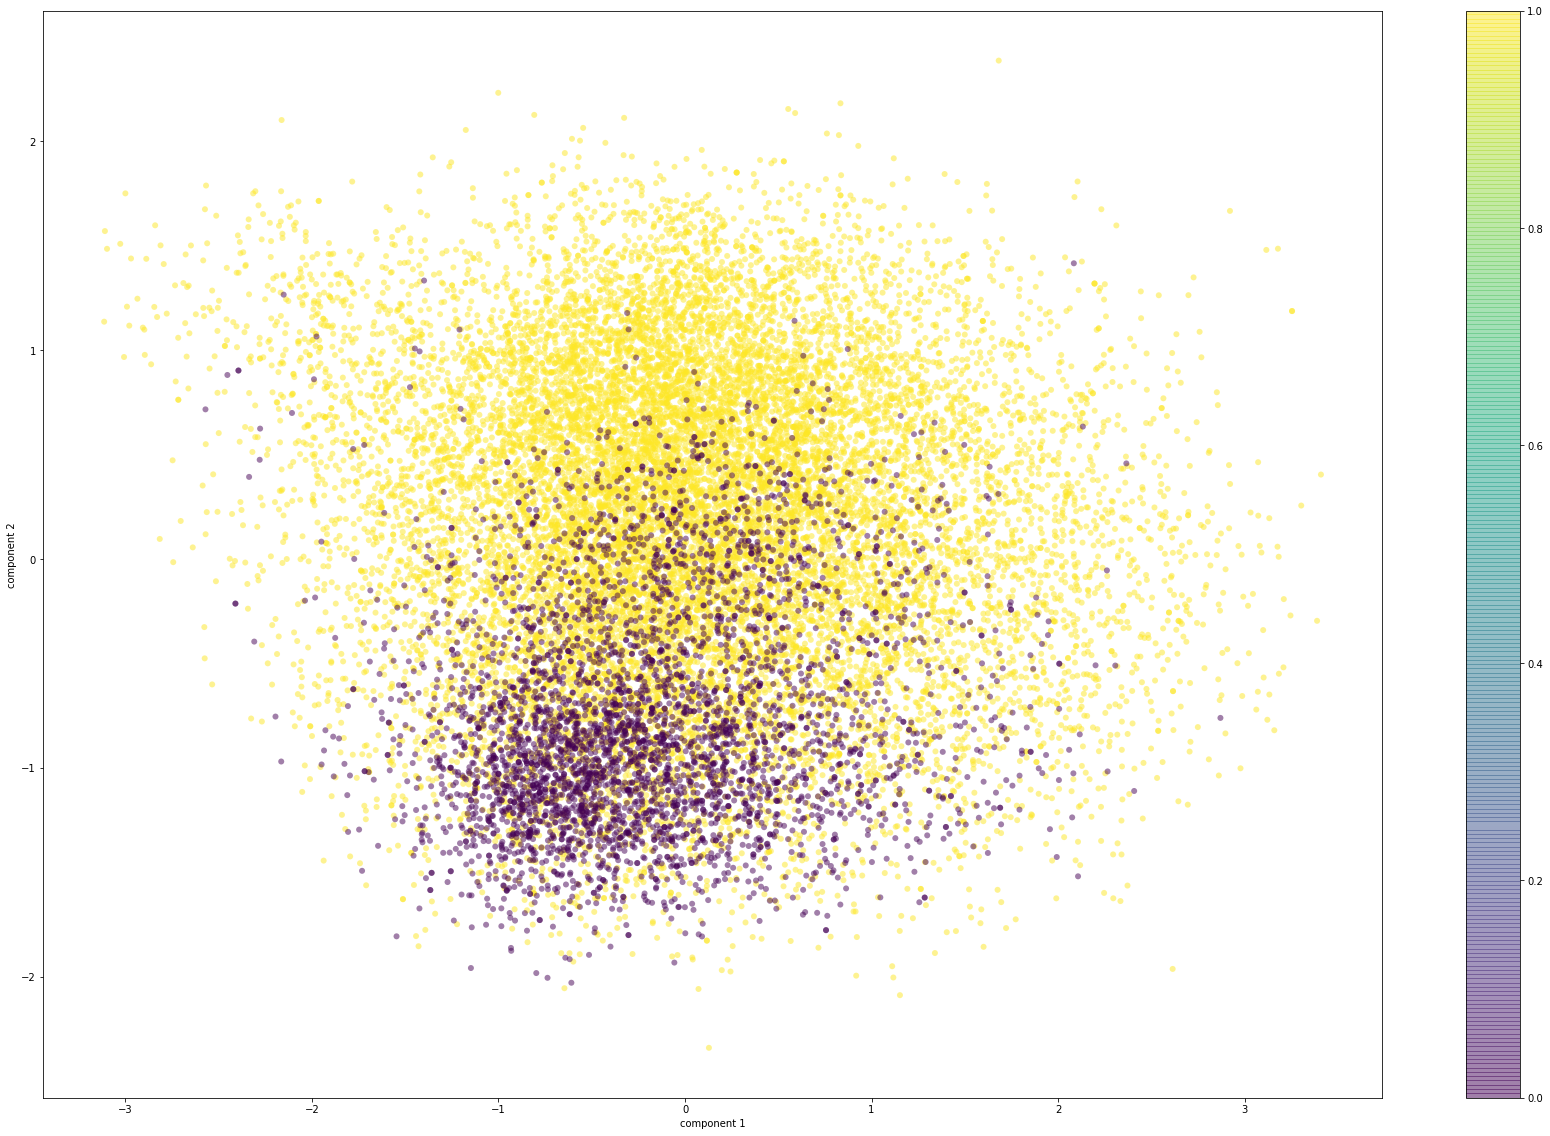

In [48]:
# Plot the PCA.
plt.scatter(pca_data[:, 0], pca_data[:, 1],
            c=labels, edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()

PCA plot. We can see two 'spots', but there is a large overlap between the two.

Text(0.5, 0, 'z axis')

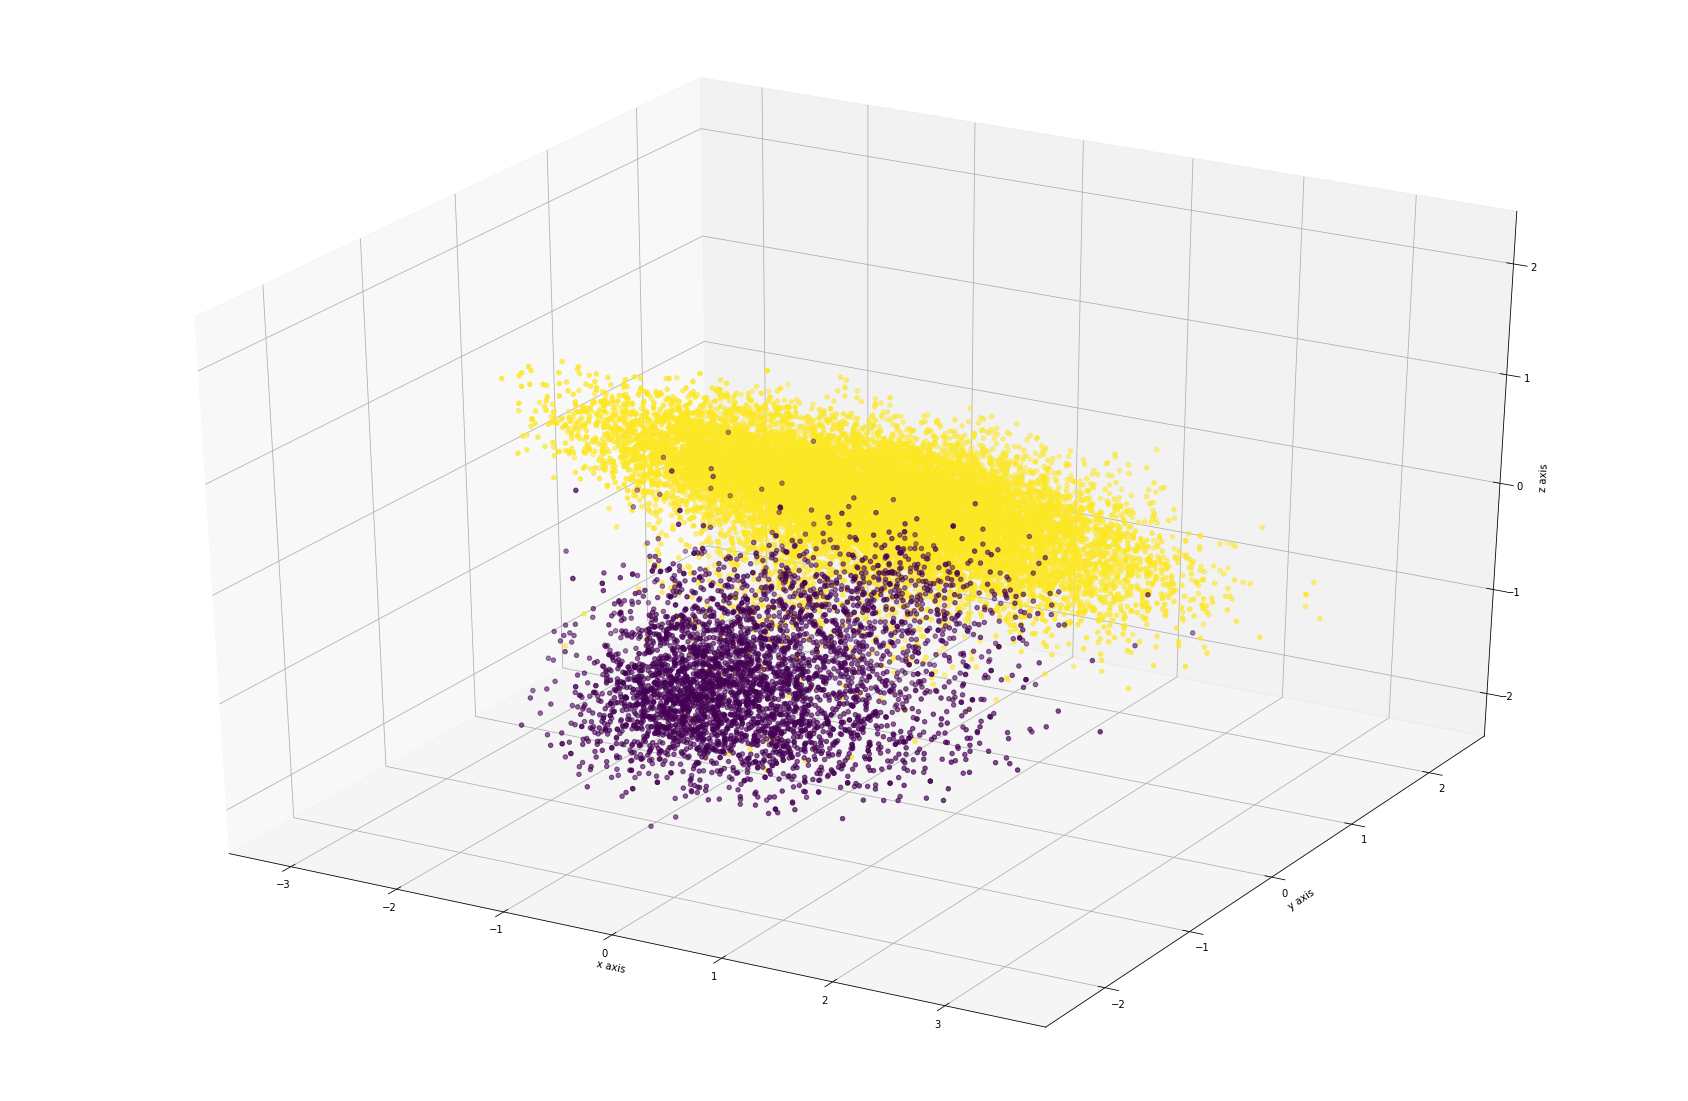

In [41]:
fig=plt.figure()
ax=fig.add_subplot(111, projection='3d')
xs,ys,zs=pca_data[:, 0], pca_data[:, 1], pca_data[:, 2]
ax.scatter(xs,ys,zs, c=labels)
ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')

Using the third principal component, we get a good separation.